In [1]:
from matplotlib import pyplot as plt
from pyasn1_modules.rfc3281 import id_mod
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
import logging
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
import MTCFeatures
from MTCFeatures import MTCFeatureLoader
import pandas as pd
from sympy.physics.units import length
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [2]:
fl = MTCFeatureLoader('MTC-FS-INST-2.0')
seqs = fl.sequences()

In [3]:
%%time
phrase_data = []
for ii, x in enumerate(seqs):
    phrase_data.append({
        'id': x['id'],
        **x['features']
    })

CPU times: total: 9.06 s
Wall time: 11.3 s


In [4]:
df = pd.DataFrame(phrase_data)

création des sous sequences

In [5]:
size = 4
step = size // 2  

subsequences = []
labels = []
ids = []
list_columns = []

for col in df.columns:
    if col != 'id' and df[col].apply(lambda x: isinstance(x, list)).all():
        list_columns.append(col)

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    song_id = row['id']
    sequence_length = len(row['scaledegree'])

    if sequence_length == 0:
        continue

    start_idx = 0
    while start_idx + size <= sequence_length: 
        end_idx = start_idx + size

        subseq = {}
        for col in list_columns:
            subseq[col] = row[col][start_idx:end_idx]
        if len(subseq['scaledegree']) == size:
            label = subseq['phrase_end'][-1]
            subsequences.append(subseq)
            labels.append(label)
            ids.append(song_id)

        start_idx += step  

    if start_idx < sequence_length:
        end_idx = sequence_length

        subseq = {}
        for col in list_columns:
            subseq[col] = row[col][start_idx:end_idx]
        if len(subseq['scaledegree']) == size:
            label = subseq['phrase_end'][-1]
            subsequences.append(subseq)
            labels.append(label)
            ids.append(song_id)

subsequences = pd.DataFrame(subsequences)
subsequences['id'] = ids
subsequences['label'] = labels

100%|██████████| 18109/18109 [01:20<00:00, 225.99it/s]


In [6]:
subsequences

,scaledegree,scaledegreespecifier,tonic,mode,metriccontour,imaweight,pitch40,midipitch,diatonicpitch,diatonicinterval,...,lbdm_sioi,lbdm_srest,lbdm_rpitch,lbdm_rioi,lbdm_rrest,lbdm_boundarystrength,durationcontour,IOR_frac,id,label
0,"[3, 1, 6, 5]","[M, P, M, P]","[C, C, C, C]","[major, major, major, major]","[None, -, -, +]","[0.798013, 0.663907, 0.150662, 0.945364]","[135, 123, 112, 106]","[64, 60, 57, 55]","[30, 28, 26, 25]","[None, -2, -2, -1]",...,"[None, 0.08928571428571427, 0.0535714285714285...","[None, 0.0, 0.0, 0.0]","[None, 0.1111111111111111, 0.14285714285714285...","[None, 0.3333333333333333, 0.0, 0.2]","[None, 0.0, 0.0, 0.0]","[None, 0.057127851140456175, 0.042391956782713...","[None, -, =, +]","[None, 1/2, 1, 3/2]",NLB125814_01,False
1,"[6, 5, 1, 1]","[M, P, P, P]","[C, C, C, C]","[major, major, major, major]","[-, +, -, +]","[0.150662, 0.945364, 0.013245, 0.524834]","[112, 106, 123, 123]","[57, 55, 60, 60]","[26, 25, 28, 28]","[-2, -1, 3, 0]",...,"[0.053571428571428575, 0.28124999999999994, 0....","[0.0, 0.0, 0.0, 0.0]","[0.14285714285714285, 0.3333333333333333, 0.71...","[0.0, 0.2, 0.5, 0.6]","[0.0, 0.0, 0.0, 0.0]","[0.04239195678271308, 0.22645933373349336, 0.0...","[=, +, -, +]","[1, 3/2, 1/3, 4]",NLB125814_01,False
2,"[1, 1, 2, 1]","[P, P, M, P]","[C, C, C, C]","[major, major, major, major]","[-, +, +, -]","[0.013245, 0.524834, 0.93543, 0.673841]","[123, 123, 129, 123]","[60, 60, 62, 60]","[28, 28, 29, 28]","[3, 0, 1, -1]",...,"[0.14732142857142858, 0.3214285714285714, 0.17...","[0.0, 0.0, 0.0, 0.0]","[0.7142857142857143, 0.5, 0.0, 0.0]","[0.5, 0.6, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.07366071428571429, 0.17710084033613444, 0.0...","[-, +, =, -]","[1/3, 4, 1, 1/2]",NLB125814_01,False
3,"[2, 1, 2, 3]","[M, P, M, M]","[C, C, C, C]","[major, major, major, major]","[+, -, -, +]","[0.93543, 0.673841, 0.195364, 0.812914]","[129, 123, 129, 135]","[62, 60, 62, 64]","[29, 28, 29, 30]","[1, -1, 1, 1]",...,"[0.17857142857142855, 0.08928571428571427, 0.0...","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.45454545454545453]","[0.0, 0.3333333333333333, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.08928571428571427, 0.04464285714285714, 0.0...","[=, -, =, =]","[1, 1/2, 1, 1]",NLB125814_01,False
4,"[2, 3, 6, 5]","[M, M, M, P]","[C, C, C, C]","[major, major, major, major]","[-, +, -, +]","[0.195364, 0.812914, 0.162252, 0.627483]","[129, 135, 112, 106]","[62, 64, 57, 55]","[29, 30, 26, 25]","[1, 1, -4, -1]",...,"[0.0, 0.0, 0.08928571428571427, 0.178571428571...","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.45454545454545453, 0.45454545454545453...","[0.0, 0.0, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.014896867838044309, 0.10427807486631016, 0....","[=, =, =, +]","[1, 1, 1, 2]",NLB125814_01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625660,"[5, 6, 5, 3]","[P, M, P, M]","[G, G, G, G]","[major, major, major, major]","[+, -, =, +]","[0.855851, 0.212766, 0.129787, 0.970213]","[169, 175, 169, 158]","[74, 76, 74, 71]","[32, 33, 32, 30]","[0, 1, -1, -2]",...,"[0.0, 0.0, 0.15873015873015875, 0.634920634920...","[0.0, 0.0, 0.0, 0.0]","[0.5, 0.0, 0.14285714285714285, 0.111111111111...","[0.0, 0.0, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.019782608695652175, 0.005652173913043478, 0...","[=, =, =, +]","[1, 1, 1, 2]",NLB179590_01,False
625661,"[5, 3, 1, 2]","[P, M, P, M]","[G, G, G, G]","[major, major, major, major]","[=, +, -, +]","[0.129787, 0.970213, 0.410106, 0.892553]","[169, 158, 146, 152]","[74, 71, 67, 69]","[32, 30, 28, 29]","[-1, -2, -2, 1]",...,"[0.15873015873015875, 0.634920634920635, 0.158...","[0.0, 0.0, 0.0, 0.0]","[0.14285714285714285, 0.1111111111111111, 0.25...","[0.0, 0.3333333333333333, 0.3333333333333333, ...","[0.0, 0.0, 0.0, 0.0]","[0.09443754313319531, 0.34603519668737065, 0.0...","[=, +, -, =]","[1, 2, 1/2, 1]",NLB179590_01,False
625662,"[1, 2, 3, 4]","[P, M, M, P]","[G, G, G, G]","[major, major, major, major]","[-, +, -, =]","[0.410106, 0.892553, 0

Choix des colones utilisés.

In [14]:
##feature_columns = ['scaledegree', 'imaweight', 'pitch40', 'midipitch', "duration", "beatinphrase", "beatinphrase_end", "IOI_frac", "IOI", "IOR", "beatstrength", "gpr2b_Frankland", "gpr2a_Frankland", "gpr_Frankland_sum", "lbdm_sioi", "lbdm_srest", "lbdm_boundarystrength", "IOR_frac", "beatfraction",  "restduration_frac", "duration_frac", "beat_fraction_str"] #colones selectionnées
#'contour5', 'scaledegreespecifier', 'tonic', 'mode', 'nextisrest', 'imacontour', 'durationcontour'
refactor = [4,5,6,7,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,44,45,46,47,84,85,86,87]

feature_arrays = []

feature_columns = ["duration", "beatinphrase", "beatinphrase_end", "IOI", "IOR", "beatstrength", "gpr2b_Frankland", "gpr_Frankland_sum", "lbdm_sioi", "lbdm_srest", "lbdm_boundarystrength"]

#refactor = [68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87 , 20, 21 ,22, 23 ,24, 25, 26 ,27 ,28,29,30,31]

for idx, row in tqdm(subsequences.iterrows(), total=subsequences.shape[0], desc="Processing subsequences"):
    feature_vector = []
    for col in feature_columns:
        feature_vector.extend(row[col])
    feature_arrays.append(feature_vector)
    #on étend les sequences.

features = np.array(feature_arrays)
labels = np.array(subsequences['label'])
ids = np.array(subsequences['id'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)



Processing subsequences: 100%|██████████| 625665/625665 [00:32<00:00, 19327.53it/s]


équilibrage des données pour l'entrainement.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    final_features,
    labels,
    test_size=1/3,
    random_state=42,
    stratify=labels)

train_data = np.column_stack((X_train, y_train))

data_majority = train_data[train_data[:, -1] == 0]
data_minority = train_data[train_data[:, -1] == 1]

if len(data_majority) > len(data_minority):
    data_majority_downsampled = resample(
        data_majority,
        replace=False,
        n_samples=len(data_minority),
        random_state=42)
    balanced_train_data = np.vstack((data_majority_downsampled, data_minority))
else:
    data_minority_downsampled = resample(
        data_minority,
        replace=False,
        n_samples=len(data_majority),
        random_state=42)
    balanced_train_data = np.vstack((data_majority, data_minority_downsampled))

np.random.shuffle(balanced_train_data)

balanced_X_train = balanced_train_data[:, :-1]
balanced_y_train = balanced_train_data[:, -1].astype(int)

balanced_X_train.shape, balanced_y_train.shape

np.unique(balanced_y_train, return_counts=True)


(array([0, 1]), array([38982, 38982], dtype=int64))

initialisation du modele RandomForest

In [17]:
model = RandomForestClassifier(random_state=42, class_weight="balanced")
model.fit(balanced_X_train, balanced_y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Résultats du modele: rapport de classification et matrice de confusion.

In [18]:
y_pred = model.predict(X_test)

print("\nClassification Report:")


print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    189064
           1       0.75      0.98      0.84     19491

    accuracy                           0.97    208555
   macro avg       0.87      0.97      0.91    208555
weighted avg       0.97      0.97      0.97    208555


Confusion Matrix:
[[182564   6500]
 [   485  19006]]


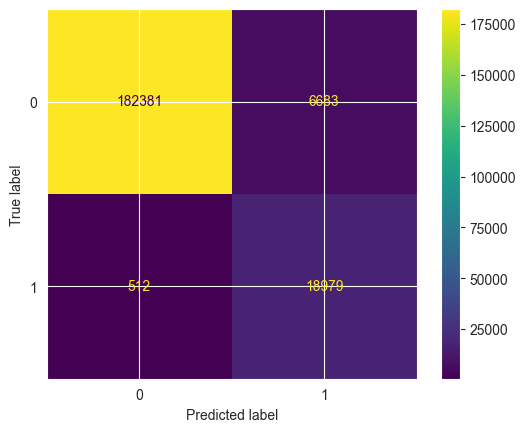

In [11]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

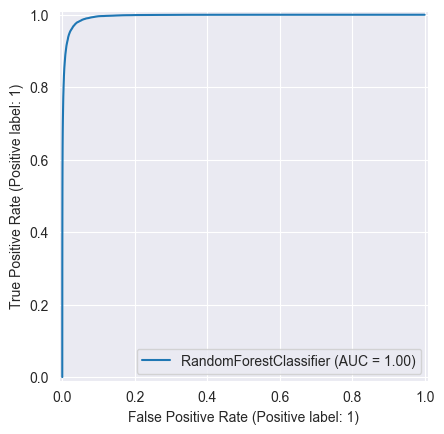

In [12]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

#models = [
#        (KNeighborsClassifier(), "KNeighborsClassifier"),
#        (DecisionTreeClassifier(), "DecisionTreeClassifier"),
#        (SGDClassifier(), "SGDClassifier"),
#        (LogisticRegression(), "LogisticRegression"),
#        (SVC(), "SVC"),
#        (GaussianNB(), "GaussianNB"),
#        (RandomForestClassifier(class_weight="balanced"),"RandomForestClassifier",),]

In [1]:
balanced_X_train

NameError: name 'balanced_X_train' is not defined

In [15]:
#for model, name in models:
#    model.fit(balanced_X_train, balanced_y_train)
#    y_pred = model.predict(X_test)
#    print(f"\nClassification Report for {name}:")
#    print(classification_report(y_test, y_pred))
#    print(f"\nConfusion Matrix for {name}:")
#    print(confusion_matrix(y_test, y_pred))

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Supposons que df est votre DataFrame et que 'target' est la colonne des étiquettes (fin de phrase ou non)
# features est une liste des colonnes des caractéristiques (séquences de notes, durées, etc.)

# Calcul de la matrice de corrélation
corr_matrix = df.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de Corrélation')
plt.show()

# Affichage des caractéristiques les plus corrélées avec la cible
corr_with_target = corr_matrix['target'].sort_values(ascending=False)
print("Corrélation avec la cible :")
print(corr_with_target)

ValueError: could not convert string to float: 'NLB125814_01'

In [19]:
list_columns = []
for col in df.columns:
    if (
        col != "id"
            and df[col].apply(lambda x: isinstance(x, list)).all()
        ):
        list_columns.append(col)
list_columns

['scaledegree',
 'scaledegreespecifier',
 'tonic',
 'mode',
 'metriccontour',
 'imaweight',
 'pitch40',
 'midipitch',
 'diatonicpitch',
 'diatonicinterval',
 'chromaticinterval',
 'pitchproximity',
 'pitchreversal',
 'nextisrest',
 'restduration_frac',
 'duration',
 'duration_frac',
 'duration_fullname',
 'onsettick',
 'beatfraction',
 'phrasepos',
 'phrase_ix',
 'phrase_end',
 'songpos',
 'beatinsong',
 'beatinphrase',
 'beatinphrase_end',
 'IOI_frac',
 'IOI',
 'IOR',
 'imacontour',
 'pitch',
 'contour3',
 'contour5',
 'beatstrength',
 'beat_str',
 'beat_fraction_str',
 'beat',
 'timesignature',
 'gpr2a_Frankland',
 'gpr2b_Frankland',
 'gpr3a_Frankland',
 'gpr3d_Frankland',
 'gpr_Frankland_sum',
 'lbdm_spitch',
 'lbdm_sioi',
 'lbdm_srest',
 'lbdm_rpitch',
 'lbdm_rioi',
 'lbdm_rrest',
 'lbdm_boundarystrength',
 'durationcontour',
 'IOR_frac']

ValueError: setting an array element with a sequence.

In [1]:
labels.values

NameError: name 'labels' is not defined

In [7]:
features

array([[1.0, 0.5, 0.5, ..., 0.057127851140456175, 0.04239195678271308,
        0.22645933373349336],
       [0.5, 0.75, 0.25, ..., 0.22645933373349336, 0.07366071428571429,
        0.17710084033613444],
       [0.25, 1.0, 1.0, ..., 0.17710084033613444, 0.08928571428571427,
        0.04464285714285714],
       ...,
       [0.5, 0.5, 0.5, ..., 0.00791304347826087, 0.017652173913043478,
        0.25],
       [0.5, 0.5, 0.5, ..., 0.25, 0.022608695652173914,
        0.005652173913043478],
       [0.5, 0.5, 0.5, ..., 0.005652173913043478, 0.1360041407867495,
        None]], dtype=object)

In [ ]:
cat_columns = [4,5,6,7,8,9,10,11,13,14,15,16,17,18,19,52,53,54,55,64,65,66,67,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,172,174,175]
refactor = [176,177,178,179,136,137,138,139,128,129,130,131,92,93,94,95,88,89,90,91,84,85,86,87,80,81,82,83,72,73,74,75,60,61,62,63]

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from fractions import Fraction

# Identifier les colonnes catégorielles et numériques
cat_columns = ['scaledegree', 'nextisrest', 'mode', 'tonic']  # Exemple pour colonnes catégoriques
num_columns = ['duration', 'midipitch', 'beatfraction', 'onsettick', 'imaweight']  # Colonnes numériques

refactor = [4,5,6,7,8,9,10,11]

for x in refactor:
    # Transformation de chaque élément dans la colonne
    features[:, x] = [
        float(Fraction(value)) if isinstance(value, str) and '/' in value else
        float(value) if value is not None else 0.0  # Remplacement des None par 0.0
        for value in features[:, x]
    ]
cat_columns = []#[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]#[84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111]
num_columns = []

# Répartition des transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), cat_columns),  # Encodage catégoriel
        ('num', StandardScaler(), num_columns)  # Normalisation des valeurs continues
    ],
    remainder='passthrough'
)

final_features = preprocessor.fit_transform(features)

In [1]:
features


NameError: name 'features' is not defined

In [48]:
subsequences

,scaledegree,scaledegreespecifier,tonic,mode,metriccontour,imaweight,pitch40,midipitch,diatonicpitch,diatonicinterval,...,lbdm_sioi,lbdm_srest,lbdm_rpitch,lbdm_rioi,lbdm_rrest,lbdm_boundarystrength,durationcontour,IOR_frac,id,label
0,"[3, 1, 6, 5]","[M, P, M, P]","[C, C, C, C]","[major, major, major, major]","[None, -, -, +]","[0.798013, 0.663907, 0.150662, 0.945364]","[135, 123, 112, 106]","[64, 60, 57, 55]","[30, 28, 26, 25]","[None, -2, -2, -1]",...,"[None, 0.08928571428571427, 0.053571428571428575, 0.28124999999999994]","[None, 0.0, 0.0, 0.0]","[None, 0.1111111111111111, 0.14285714285714285, 0.3333333333333333]","[None, 0.3333333333333333, 0.0, 0.2]","[None, 0.0, 0.0, 0.0]","[None, 0.057127851140456175, 0.04239195678271308, 0.22645933373349336]","[None, -, =, +]","[None, 1/2, 1, 3/2]",NLB125814_01,False
1,"[6, 5, 1, 1]","[M, P, P, P]","[C, C, C, C]","[major, major, major, major]","[-, +, -, +]","[0.150662, 0.945364, 0.013245, 0.524834]","[112, 106, 123, 123]","[57, 55, 60, 60]","[26, 25, 28, 28]","[-2, -1, 3, 0]",...,"[0.053571428571428575, 0.28124999999999994, 0.14732142857142858, 0.3214285714285714]","[0.0, 0.0, 0.0, 0.0]","[0.14285714285714285, 0.3333333333333333, 0.7142857142857143, 0.5]","[0.0, 0.2, 0.5, 0.6]","[0.0, 0.0, 0.0, 0.0]","[0.04239195678271308, 0.22645933373349336, 0.07366071428571429, 0.17710084033613444]","[=, +, -, +]","[1, 3/2, 1/3, 4]",NLB125814_01,False
2,"[1, 1, 2, 1]","[P, P, M, P]","[C, C, C, C]","[major, major, major, major]","[-, +, +, -]","[0.013245, 0.524834, 0.93543, 0.673841]","[123, 123, 129, 123]","[60, 60, 62, 60]","[28, 28, 29, 28]","[3, 0, 1, -1]",...,"[0.14732142857142858, 0.3214285714285714, 0.17857142857142855, 0.08928571428571427]","[0.0, 0.0, 0.0, 0.0]","[0.7142857142857143, 0.5, 0.0, 0.0]","[0.5, 0.6, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.07366071428571429, 0.17710084033613444, 0.08928571428571427, 0.04464285714285714]","[-, +, =, -]","[1/3, 4, 1, 1/2]",NLB125814_01,False
3,"[2, 1, 2, 3]","[M, P, M, M]","[C, C, C, C]","[major, major, major, major]","[+, -, -, +]","[0.93543, 0.673841, 0.195364, 0.812914]","[129, 123, 129, 135]","[62, 60, 62, 64]","[29, 28, 29, 30]","[1, -1, 1, 1]",...,"[0.17857142857142855, 0.08928571428571427, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.45454545454545453]","[0.0, 0.3333333333333333, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.08928571428571427, 0.04464285714285714, 0.014896867838044309, 0.10427807486631016]","[=, -, =, =]","[1, 1/2, 1, 1]",NLB125814_01,False
4,"[2, 3, 6, 5]","[M, M, M, P]","[C, C, C, C]","[major, major, major, major]","[-, +, -, +]","[0.195364, 0.812914, 0.162252, 0.627483]","[129, 135, 112, 106]","[62, 64, 57, 55]","[29, 30, 26, 25]","[1, 1, -4, -1]",...,"[0.0, 0.0, 0.08928571428571427, 0.17857142857142855]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.45454545454545453, 0.45454545454545453, 0.5]","[0.0, 0.0, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.014896867838044309, 0.10427807486631016, 0.0759262796027502, 0.08928571428571427]","[=, =, =, +]","[1, 1, 1, 2]",NLB125814_01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625660,"[5, 6, 5, 3]","[P, M, P, M]","[G, G, G, G]","[major, major, major, major]","[+, -, =, +]","[0.855851, 0.212766, 0.129787, 0.970213]","[169, 175, 169, 158]","[74, 76, 74, 71]","[32, 33, 32, 30]","[0, 1, -1, -2]",...,"[0.0, 0.0, 0.15873015873015875, 0.634920634920635]","[0.0, 0.0, 0.0, 0.0]","[0.5, 0.0, 0.14285714285714285, 0.1111111111111111]","[0.0, 0.0, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.019782608695652175, 0.005652173913043478, 0.09443754313319531, 0.34603519668737065]","[=, =, =, +]","[1, 1, 1, 2]",NLB179590_01,False
625661,"[5, 3, 1, 2]","[P, M, P, M]","[G, G, G, G]","[major, major, major, major]","[=, +, -, +]","[0.129787, 0.970213, 0.410106, 0.892553]","[169, 158, 146, 152]","[74, 71, 67, 69]","[32, 30, 28, 29]","[-1, -2, -2, 1]",...,"[0.15873015873015875, 0.634920634920635, 0.15873015873015875, 0.0]","[0.0, 0.0, 0.0, 0.0]

In [35]:
full_range = set(range(63))  # Ensemble de nombre de 0 à 199
given_numbers = set(
    [8,9,10,11,16,17,18,19,20,21,22,23,28,29,30,31,32,33,34,35,48,49,50,51,56,57,58,59]
)
missing_numbers = sorted(full_range - given_numbers)  # Différence entre l'ensemble complet et les nombres donnés
print(missing_numbers)

[0, 1, 2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 52, 53, 54, 55, 60, 61, 62]


In [42]:
new_cat =[]

for x in num_columns:
    new_cat.append(x-4)

print(new_cat)

[8, 20, 21, 22, 23, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 56, 57, 58, 59]
